# Project Overview

This is the capstone project of Udacity's Data Science Nanodegree. The objective is to utilize Big Data technologies to predict customer churn on a music streaming app, aptly named "Sparkify". To our help we have a dataset with user interactions, such as songs played, friends added and thumbs up/down. Each interaction also contains information about the user, such as gender and device used. The full code can be found at 

## Imports

In [232]:
# standard python libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics
from IPython.display import display_html
from inspect import signature

# spark and pyspark.sql libs
import ibmos2spark
from project_lib import Project
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t

# pyspark.ml libs
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, OneHotEncoderEstimator, MinMaxScaler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Settings

In [233]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 8, 6

## Set up cluster and read in dataset

In [234]:
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-831012fc-ab47-4233-9f51-132a56d7e2d3',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': '38qBg0jvppqN8J6KhN_x8feM8dQD7M4qBGEDJ8A_c2co'
}

configuration_name = 'os_dee56333f8fe430da6b3713c9464da54_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-9rd2ra6j6vxxcf'))
df.take(3)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [235]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(spark.sparkContext, 'dda0375a-6dbd-4640-a68c-e80389159369', 'p-14d8e5f9ff3224993e6ca5a5283f1cdf5e03d434')
pc = project.project_context

## Clean dataset

In [236]:
# optionally, subsample data further for quicker exploration
#df = df.sample(False, 0.1, seed = 1337)

In [237]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Dates
Convert long format to timestamps

In [238]:
convert_to_timestamp = f.udf(lambda x: f.from_unixtime(x/1000), t.TimestampType())

df = df.withColumn("dateTime", f.from_unixtime(df["ts"]/1000))
df = df.withColumn("registrationDate", f.from_unixtime(df["registration"]/1000))
df.select('dateTime', 'registrationDate').take(1)

[Row(dateTime='2018-10-01 00:00:11', registrationDate='2018-07-20 05:11:47')]

#### Filter out non-logged in users
Filter out guests and logged out users, as they have no ID to link activity to (though we can use sessionId to link logged out users, this is generally not considered ethical and possibly illegal)

In [239]:
df = df.filter(df["auth"].isin(["Logged In", 'Cancelled']))
df.count()

528005

#### Parse technical details

In [240]:
#split_column = f.udf(lambda col, sep, i: f.split(col, sep)[i])

tech_variables = f.split(df['userAgent'], ' ')
df = df.withColumn('browser', f.translate(f.split(tech_variables[0], '/')[0], '"',''))
df = df.withColumn('device', f.translate(f.split(tech_variables[1], '\(')[1], ';', ''))
#df.withColumn('temp', f.translate(tech_variables[2], ';', ''))

#### Parse location data

In [241]:
states = f.split(df['location'], ',')
df = df.withColumn('state', states[1])

#### Add churn variable


In [242]:
#df.filter(df["page"]=='Cancellation Confirmation').select('auth', 'page').distinct().show()
df = df.withColumn("churn", f.when(df["auth"]=='Cancelled', 1).otherwise(0) )

#### Exclude post-churn events
Filter out data to only include non-churned users or activity up until churn event

In [243]:
has_churned = df.select('userId', 'churn').groupBy('userId').agg(f.max('churn').alias('hasChurned'))
churn_ts = df.filter(df['churn']==1).select('userId', 'dateTime').groupBy('userId').agg(f.min('dateTime').alias('churnTs'))

In [244]:
df = df.join(churn_ts, ['userId'], how='left').join(has_churned, ['userId'], how='left')
df = df.filter( (df['hasChurned']==0) | (df['dateTime']<df['churnTs']) )

#### Page visits
Count how many times each user has visited each page. Note that we exclude pages related to cancellation, i.e. variables related to the target event

In [245]:
df.select('page', 'method').distinct().show()

+----------------+------+
|            page|method|
+----------------+------+
|      Add Friend|   PUT|
|          Logout|   PUT|
|           About|   GET|
|  Submit Upgrade|   PUT|
| Add to Playlist|   PUT|
|          Cancel|   PUT|
|Submit Downgrade|   PUT|
|        Settings|   GET|
|   Save Settings|   PUT|
|            Help|   GET|
|       Downgrade|   GET|
|         Upgrade|   GET|
|           Error|   GET|
|     Thumbs Down|   PUT|
|            Home|   GET|
|     Roll Advert|   GET|
|        NextSong|   PUT|
|       Thumbs Up|   PUT|
+----------------+------+



In [246]:
pages_to_exclude = ['Cancel', 'Cancellation Confirmation']
page_visits = df.filter(~df.page.isin(pages_to_exclude)).groupBy('userId').pivot('page').count().fillna(0)

#### Derive user attributes

Derive attributes related to the user (i.e., not to individual actions). Due to Spark's limitations in terms of udfs this is not easily solved through functions, hence the breaking of DRY-principles.

In [247]:
#most_common_value = f.udf(lambda col: df.groupby("userId", col)
#        .count()
#        .withColumn("count_"+col, f.array("count", col))
#        .groupby("userId")
#        .agg(f.max("count_"+col).getItem(1).alias(col)), t.StringType())
#
#most_common_value('gender')

In [248]:
device = (
    df.groupby("userId", "device")
    .count()
    .withColumn("count_device", f.array("count", "device"))
    .groupby("userId")
    .agg(f.max("count_device").getItem(1).alias("most_common_device"))
)

browser = (
    df.groupby("userId", "browser")
    .count()
    .withColumn("count_browser", f.array("count", "browser"))
    .groupby("userId")
    .agg(f.max("count_browser").getItem(1).alias("most_common_browser"))
)

state = (
    df.groupby("userId", "state")
    .count()
    .withColumn("count_state", f.array("count", "state"))
    .groupby("userId")
    .agg(f.max("count_state").getItem(1).alias("most_common_state"))
)

gender = (
    df.groupby("userId", "gender")
    .count()
    .withColumn("count_gender", f.array("count", "gender"))
    .groupby("userId")
    .agg(f.max("count_gender").getItem(1).alias("gender"))
) 

user_stats = device.join(browser, ['userId'], how='left').join(gender, ['userId'], how='left').join(state, ['userId'], how='left')

#### Calculate activity statistics

In [249]:
plays = df.filter(df['page']=='NextSong').groupBy('userId', 'sessionId').agg(f.count('page').alias('plays')).groupBy('userId').agg(f.avg('plays').alias('avgPlays'), f.max('plays').alias('maxPlays'))

In [250]:
activity = df.groupBy('userId').agg(((f.max('ts')-f.min('registration'))/1000).alias('timeSinceRegistration'), f.max("itemInSession").alias('maxItems'), f.countDistinct("sessionId").alias('sessionsCount'))

In [251]:
_length = f.udf(lambda x: max(x)-min(x), t.LongType())

session_duration = df.groupby(['userId','sessionId']).agg(f.collect_list('ts').alias('ts'))
session_duration = session_duration.withColumn('duration', _length('ts')/1000)
session_duration = session_duration.select(['userId','sessionId','duration'])
session_duration = session_duration.groupby('userId').agg(f.avg('duration').alias('avg_session_duration'), f.max('duration').alias('max_session_duration'))

dfa = user_stats.join(session_duration, ['userId'], how='left').join(plays, ['userId'], how='left')

In [252]:
dfa = dfa.join(activity, ['userId'], how='left').join(page_visits, ['userId'], how='left').join(has_churned, ['userId'], how='left')

dfp = dfa.toPandas()
dfp.head()

,userId,most_common_device,most_common_browser,gender,most_common_state,avg_session_duration,max_session_duration,avgPlays,maxPlays,timeSinceRegistration,...,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,hasChurned
0,100010,iPhone,Mozilla,F,CT,12616.000000,13354.0,48.000000,49,1237965.0,...,96,22,0,0,0,0,3,4,2,1
1,200002,iPhone,Mozilla,M,IL-IN-WI,15782.600000,27244.0,62.000000,105,4607115.0,...,310,11,0,2,0,1,5,15,2,1
2,296,Macintosh,Mozilla,F,PA-NJ,5780.200000,14783.0,22.400000,55,2301336.0,...,112,9,0,1,0,1,0,8,1,1
3,125,Macintosh,Mozilla,M,TX,5099.000000,12965.0,20.666667,53,9108471.0,...,62,6,0,3,0,0,1,3,0,0
4,124,Macintosh,Mozilla,F,NJ,26738.823529,76852.0,114.125000,313,9724627.0,...,1826,1,3,15,0,0,15,102,0,1


#### Save cleaned and aggregated dataframe

In [253]:
project.save_data(data=dfp.to_csv(index=False), file_name='aggregated-sparkify-event-data.csv', overwrite=True)

{'file_name': 'aggregated-sparkify-event-data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'sparkify-donotdelete-pr-9rd2ra6j6vxxcf',
 'asset_id': '801b3ab6-461c-4456-a96b-4259f0884840'}

## Exploration

In [254]:
#dfa = spark.read.format("csv").option("header", "true").load(cos.url('aggregated-sparkify-event-data.csv', 'sparkify-donotdelete-pr-9rd2ra6j6vxxcf'))
#dfp = dfa.toPandas()
#dfp.loc[:, 'avg_session_duration':'timeSinceRegistration'] = dfp.loc[:, 'avg_session_duration':'timeSinceRegistration'].astype(float)
#dfp.loc[:, 'maxItems':] = dfp.loc[:, 'maxItems':].astype(int)
#dfp.head()

In [255]:
dfp.describe(include=['O'])

,userId,most_common_device,most_common_browser,gender,most_common_state
count,448,448,448,448,448
unique,448,6,1,2,70
top,100044,Windows,Mozilla,M,CA
freq,1,209,448,250,62


,gender,hasChurned,users
0,F,0,153
1,F,1,45
2,M,0,196
3,M,1,54


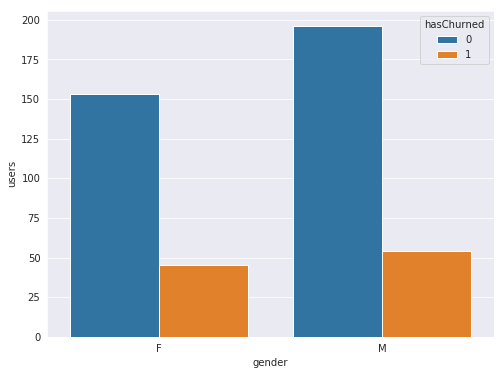

In [256]:
gender = dfp.groupby(['gender', 'hasChurned'])['userId'].count().reset_index().rename(columns={'userId':'users'}) #.plot(x='gender', kind='bar')
sns.barplot(data=gender, x='gender', y ='users', hue='hasChurned');
gender

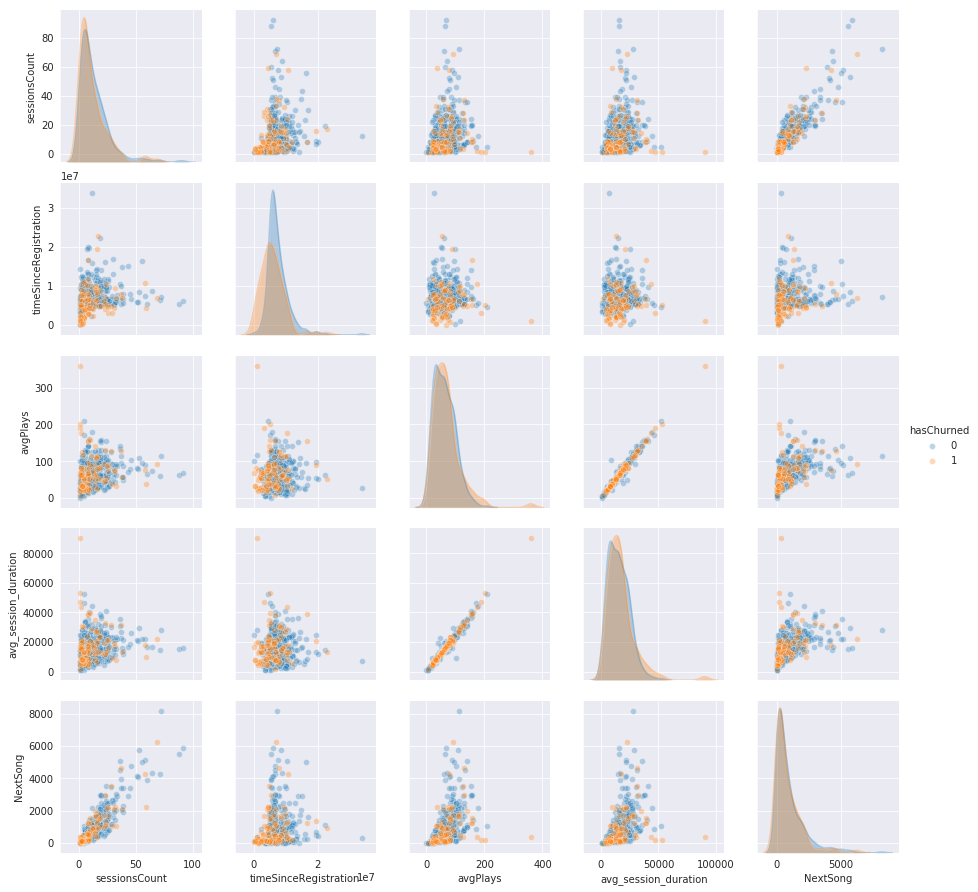

In [257]:
cols = ['sessionsCount', 'timeSinceRegistration', 'avgPlays', 'avg_session_duration', 'NextSong']
sns.pairplot(dfp, vars=cols, hue='hasChurned', kind='scatter', diag_kws= {'alpha': 0.3}, plot_kws= {'alpha': 0.3} )

The plot above shows churners having lower frequencies across all metrics, indicating that overall low activity is the most predictive feature of churn. To make use of additional features, we will probably have to "normalize" activity data in some way, e.g. by dividing by sessions, time frame or similar. 

In [258]:
dfp_norm = dfp.copy()
dfp_norm.loc[:,'About':'Upgrade'] = dfp_norm.loc[:,'About':'Upgrade'].div(dfp['sessionsCount'], axis=0)

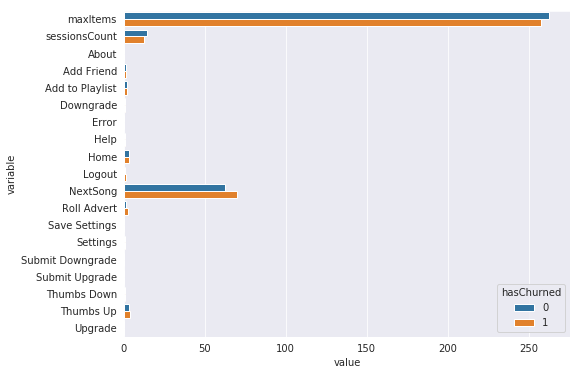

In [259]:
dfm = dfp_norm.loc[:, 'maxItems':].melt(id_vars=['hasChurned'])
sns.barplot(data=dfm, y='variable', x='value', hue='hasChurned', estimator=np.mean, ci=None)

## Modelling

In [291]:
# convert back to spark dataframe
dfa = spark.createDataFrame(dfp_norm)

# split into train and test sets
train, test = dfa.randomSplit([0.7, 0.3], seed=1337)
    
# specify categorical and numerical input variables
encoding_vars = dfp.select_dtypes(include='O').columns.drop('userId').tolist()
num_vars = dfp.select_dtypes(include=np.number).columns.drop('hasChurned').tolist()

# define transformers
string_indexes = [StringIndexer(inputCol = c, outputCol = 'IDX_' + c, handleInvalid = 'keep') for c in encoding_vars]
onehot_indexes = [OneHotEncoderEstimator(inputCols = ['IDX_' + c], outputCols = ['OHE_' + c]) for c in encoding_vars]
label_indexes = StringIndexer(inputCol = 'hasChurned', outputCol = 'label', handleInvalid = 'keep')
assembler = VectorAssembler(inputCols = num_vars + ['OHE_' + c for c in encoding_vars], outputCol = "features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# define candidate estimators
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="hasChurned", seed=1337, cacheNodeIds=True)
lr = LogisticRegression(featuresCol="scaled_features", labelCol="hasChurned")
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="hasChurned")
nb = NaiveBayes(featuresCol="scaled_features", labelCol="hasChurned", smoothing=1.0)
dt = DecisionTreeClassifier(labelCol="scaled_features", featuresCol="hasChurned")

model_candidates = [lr, rf, gbt]

# define grid, evaluator and target labels
paramGrid = ParamGridBuilder().build() 
evaluator = BinaryClassificationEvaluator(labelCol='hasChurned', metricName='areaUnderROC')
labels = test.select('hasChurned').toPandas().hasChurned.values

# try a range of different models
models = []
for model in model_candidates:
    # set up pipeline
    pipeline = Pipeline(stages = string_indexes + onehot_indexes + [assembler, scaler, label_indexes, model])
    cv = CrossValidator(estimator=pipeline, 
                   estimatorParamMaps=paramGrid, 
                   evaluator=evaluator,
                   numFolds=3)
    # train model
    model = cv.fit(train)
    models.append(model)


In [292]:
summary = []
for i, model in enumerate(models):
    predictions = model.transform(test)
    score = evaluator.evaluate(predictions)
    name = model.bestModel.stages[-1].__dict__['uid'].split('_')[0]
    summary.append({'name':name, 'score':score})

models_summary2 = pd.DataFrame.from_dict(summary).sort_values('score', ascending=False) #.reset_index()
idxmax = models_summary2.iloc[0,:].name #['index']

In [293]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
display_side_by_side(models_summary, models_summary2)

,name,score
1,RandomForestClassifier,0.779407
0,LogisticRegression,0.662105
2,GBTClassifier,0.650375
,name,score
1,RandomForestClassifier,0.763441
0,LogisticRegression,0.730857
2,GBTClassifier,0.705116


In [275]:
def get_estimator(models, summary, name):
    return models[summary[summary.name==name].index[0]].bestModel.stages[-1]

rfModel = get_estimator(models, models_summary, 'RandomForestClassifier')
lrModel = get_estimator(models, models_summary, 'LogisticRegression') 
gbtModel = get_estimator(models, models_summary, 'GBTClassifier') 

In [276]:
best_model = models[idxmax]
predictions = best_model.transform(test)
prediction_prob = predictions.toPandas()['probability'].str[1]

#### Feature importance

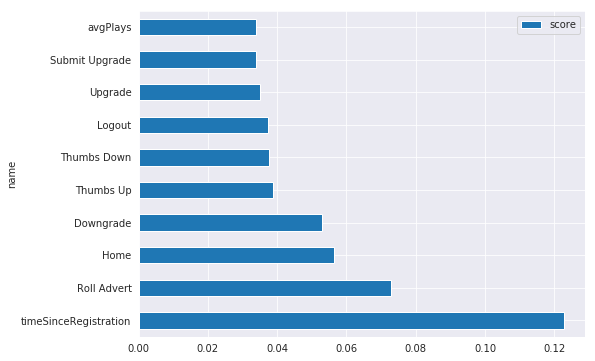

In [277]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

ExtractFeatureImp(rfModel.featureImportances, predictions, "features").head(10).drop('idx', axis=1).plot(kind='barh', x='name');

In [284]:
def find_threshold(trainingSummary):
    fMeasure = trainingSummary.fMeasureByThreshold
    maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
    bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
        .select('threshold').head()['threshold']
    return bestThreshold

trainingSummary = lrModel.summary
# Set the model threshold to maximize F-Measure
bestThreshold = optimize_threshold(lrModel)[1]
#lrModel.setThreshold(bestThreshold)

print("Best threshold: " + str(bestThreshold))

Best threshold: 0.45532518868198135


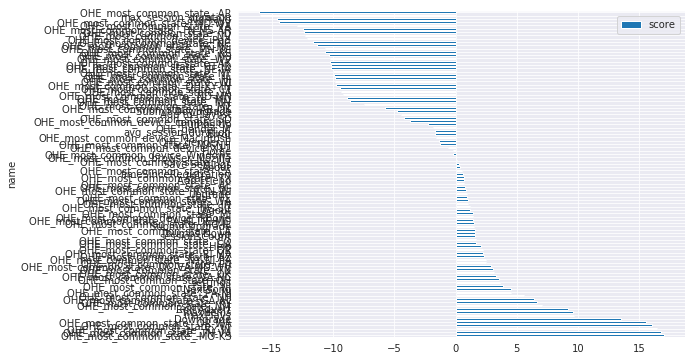

In [285]:
log_feature_importance = {key:val for key, val in zip(range(len(lrModel.coefficients)), lrModel.coefficients) }
ExtractFeatureImp(log_feature_importance, predictions, "features").drop('idx', axis=1).plot(kind='barh', x='name');

In [ ]:
predictions.schema

#### AUROC

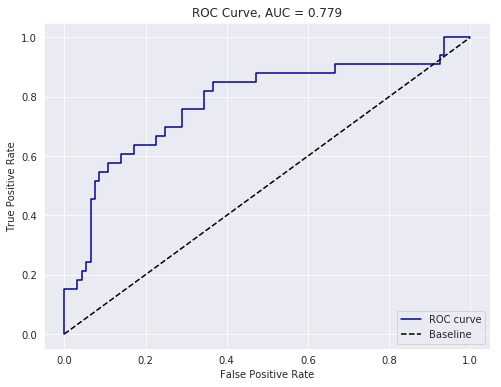

In [286]:
def plot_roc(prediction_prob, labels):
    ''' Plot a receiver operating curve '''
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_prob)
    auc = "%.3f" % metrics.auc(fpr, tpr)
    title = 'ROC Curve, AUC = '+str(auc)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "#000099", label='ROC curve')
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    plt.legend(loc='lower right')

plot_roc(prediction_prob, labels)

#### Precision-Recall

,threshold,precision,recall
0,0.097841,0.275000,1.000000
1,0.098255,0.268908,0.969697
2,0.098437,0.262712,0.939394
3,0.098641,0.264957,0.939394
4,0.100568,0.258621,0.909091


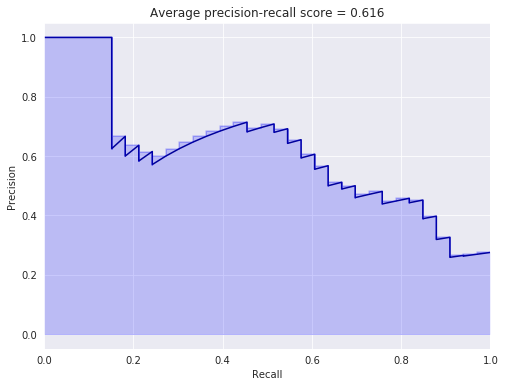

In [279]:
def plot_pr_curver(prediction_prob, labels):
    ''' Plot a receiver operating curve '''
    precision, recall, thresholds = metrics.precision_recall_curve(labels, prediction_prob)
    pr_summary = pd.DataFrame([thresholds, precision, recall]).T
    pr_summary.columns = ['threshold', 'precision', 'recall']
    auc = "%.3f" % metrics.average_precision_score(labels, prediction_prob)
    title = 'Average precision-recall score = '+str(auc)  
    fig, ax = plt.subplots()
    ax.plot(recall, precision, "#000099")
    
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.set_xlim((0,1))
    return pr_summary

pr_summary = plot_pr_curver(prediction_prob, labels)
pr_summary.head()